In [2]:
import os
import kagglehub
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics

In [3]:
# Download latest version
path = kagglehub.dataset_download("samayashar/fraud-detection-transactions-dataset")

print("Path to dataset files:", path)

# Get the list of files in the downloaded directory
files = os.listdir(path)

# Find the CSV file and load it
csv_file = [f for f in files if f.endswith('.csv')][0]
csv_file_path = os.path.join(path, csv_file)
df = pd.read_csv(csv_file_path)

Path to dataset files: C:\Users\Dell\.cache\kagglehub\datasets\samayashar\fraud-detection-transactions-dataset\versions\1


In [4]:
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [5]:
df.columns

Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Timestamp', 'Account_Balance', 'Device_Type', 'Location',
       'Merchant_Category', 'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
       'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend', 'Fraud_Label'],
      dtype='object')

In [6]:
df.shape

(50000, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64

In [10]:
def shows_how_many_fraud_transaction_for_category(name):
  # Calculate the counts for each category
  category_counts = df[name].value_counts().reset_index()
  category_counts.columns = [name, 'count']
  category_counts = category_counts.sort_values(by='count', ascending=False)
  plt.figure(figsize =(15,6))
  ax = sns.countplot(data=df,
                    x=name,
                    palette = ["#ebc1b7", "#9ac8ed"],
                    hue='Fraud_Label',
                    order=category_counts[name])

  for p in ax.patches:
      ax.annotate(
          f'{p.get_height()}',
          (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center',
          va='bottom')

  plt.xlabel(name.replace('_', ' '))
  plt.ylabel("")

  plt.title(f"Count of Fraud Transaction by {name.replace('_', ' ')}",
            size=14,
            weight="bold")

  plt.legend(title='Fraud',
            labels=['Not Fraud', 'Fraud'])

  sns.despine(left=True, bottom=True)
  plt.show()

In [11]:
def shows_percentage_of_fraud_transaction_for_category(name):
  # Create a cross-tabulation of category and Fraud
  ct = round(pd.crosstab(df[name],
                        df['Fraud_Label'],
                        normalize='index') * 100,1)

  plt.figure(figsize=(15, 5))

  ax = ct.plot(kind='barh',
              stacked=True,
              color= ["#ebc1b7", "#9ac8ed"])

  plt.ylabel(name.replace('_', ' '))
  plt.xlabel("")

  plt.title(f"Percentage of Fraud by {name.replace('_', ' ')}",
            size=14,
            weight="bold")

  plt.legend(title='Fraud',
            labels=['Not Fraud', 'Fraud'],
            bbox_to_anchor=(1, 1))

  for container in ax.containers:
      ax.bar_label(container,
                  label_type='center',
                  fontsize=9,
                  color='black')

  sns.despine(left=True, bottom=True)
  plt.show();

In [12]:
def show_distribution(name, data):
  plt.figure(figsize=(15, 6))

  sns.histplot(data=data,
              x=name,
              kde=True,
              color="#d6a69a")

  plt.xlabel(name.replace('_', ' '))
  plt.ylabel("")

  plt.title(f"Diustribution of {name.replace('_', ' ')}",
            size=14,
            weight="bold")

  sns.despine(left=True, bottom=True)
  plt.show()

In [13]:
def show_present_of_outliers(name, data):
  plt.figure(figsize=(8, 6))

  sns.boxplot(data=data,
              x='Fraud_Label',
              y=name,
              orient='v',
              palette = ["#ebc1b7", "#9ac8ed"])

  plt.xlabel('Fraud')
  plt.ylabel("")

  plt.title(f"Relationship between Fraud and {name.replace('_', ' ')}",
            size=12,
            weight="bold")

  sns.despine(left=True, bottom=True)
  plt.show()
  pass

In [14]:
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         50000 non-null  object
 1   User_ID                50000 non-null  object
 2   Transaction_Type       50000 non-null  object
 3   Timestamp              50000 non-null  object
 4   Device_Type            50000 non-null  object
 5   Location               50000 non-null  object
 6   Merchant_Category      50000 non-null  object
 7   Card_Type              50000 non-null  object
 8   Authentication_Method  50000 non-null  object
dtypes: object(9)
memory usage: 3.4+ MB


In [15]:
df.Transaction_Type.unique()

array(['POS', 'Bank Transfer', 'Online', 'ATM Withdrawal'], dtype=object)

In [16]:
df.Transaction_Type.value_counts()

Transaction_Type
POS               12549
Online            12546
ATM Withdrawal    12453
Bank Transfer     12452
Name: count, dtype: int64

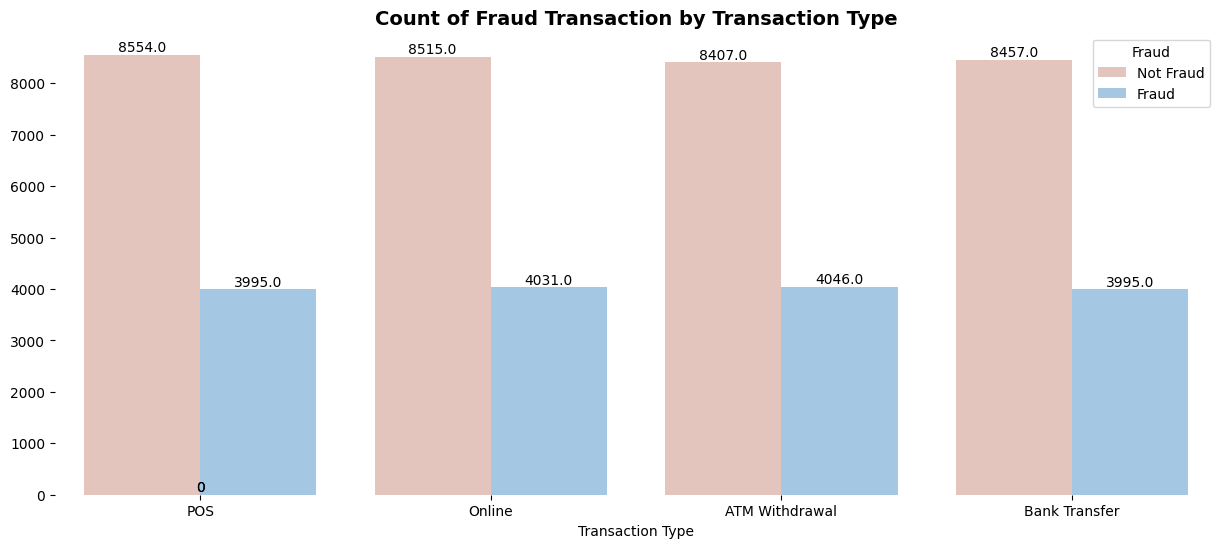

In [17]:
shows_how_many_fraud_transaction_for_category("Transaction_Type")

<Figure size 1500x500 with 0 Axes>

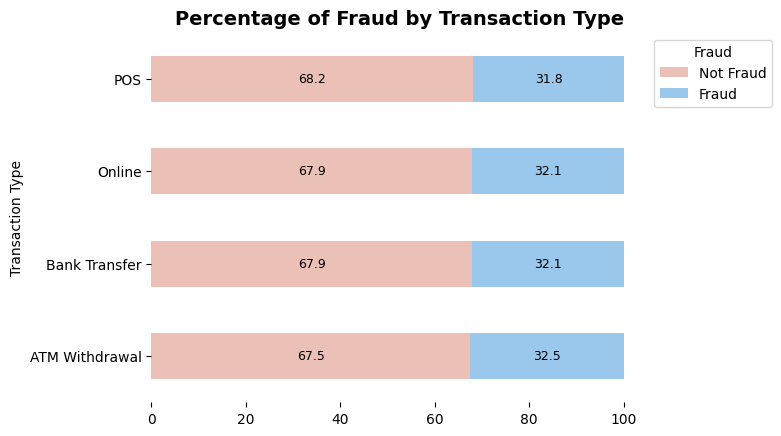

In [18]:
shows_percentage_of_fraud_transaction_for_category("Transaction_Type")

In [19]:
df.Device_Type.unique()

array(['Laptop', 'Mobile', 'Tablet'], dtype=object)

In [20]:
df.Device_Type.value_counts()

Device_Type
Tablet    16779
Mobile    16640
Laptop    16581
Name: count, dtype: int64

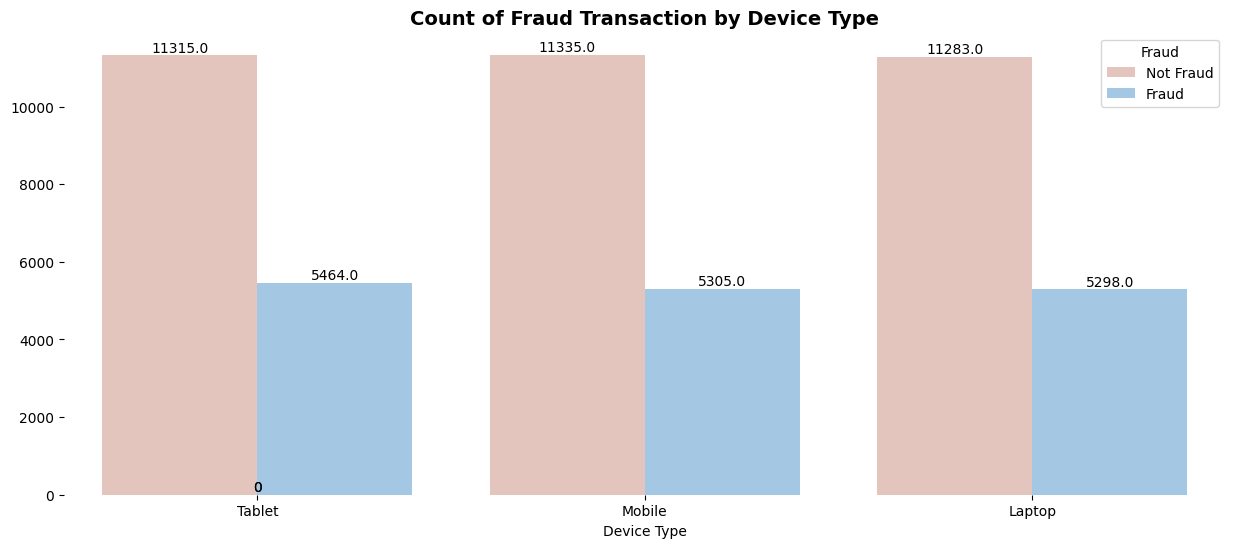

In [21]:
shows_how_many_fraud_transaction_for_category("Device_Type")

<Figure size 1500x500 with 0 Axes>

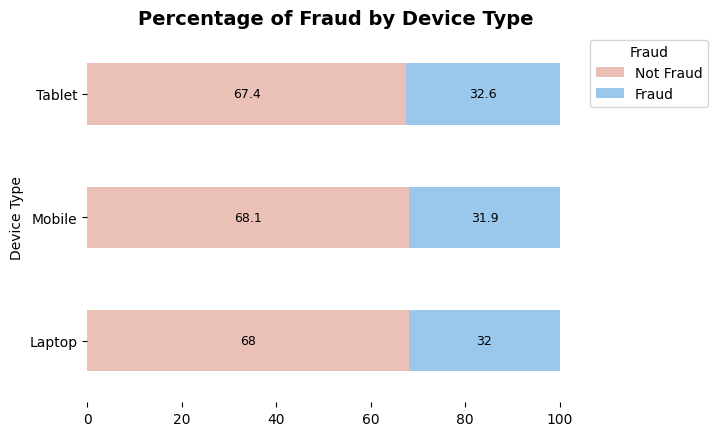

In [22]:
shows_percentage_of_fraud_transaction_for_category("Device_Type")

In [23]:
df.Location.unique()

array(['Sydney', 'New York', 'Mumbai', 'Tokyo', 'London'], dtype=object)

In [24]:
df.Location.value_counts()

Location
Tokyo       10208
Mumbai       9994
London       9945
Sydney       9938
New York     9915
Name: count, dtype: int64

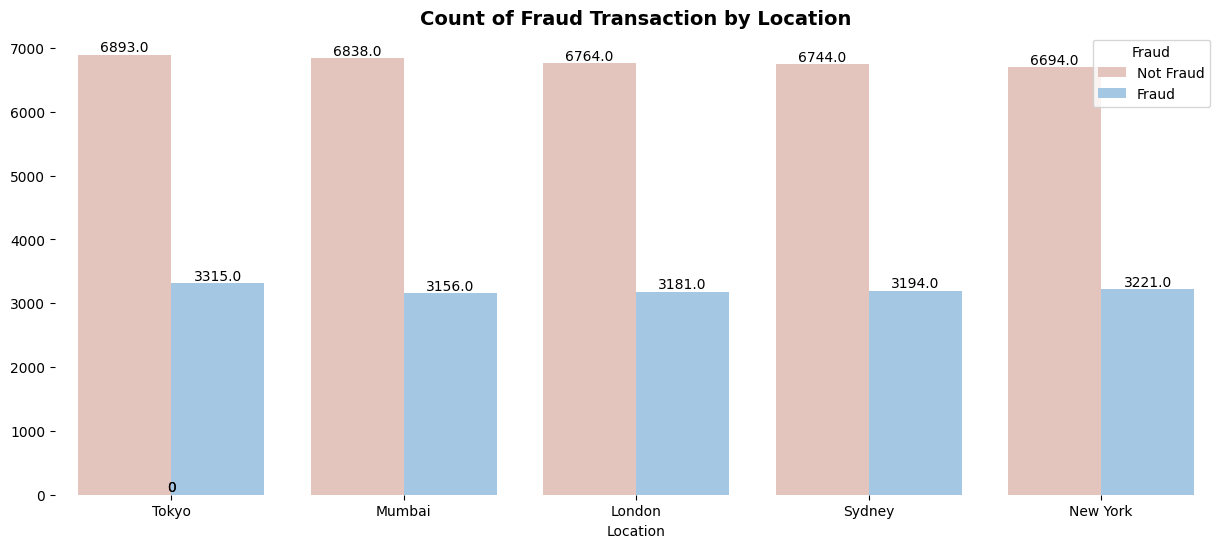

In [25]:
shows_how_many_fraud_transaction_for_category("Location")

<Figure size 1500x500 with 0 Axes>

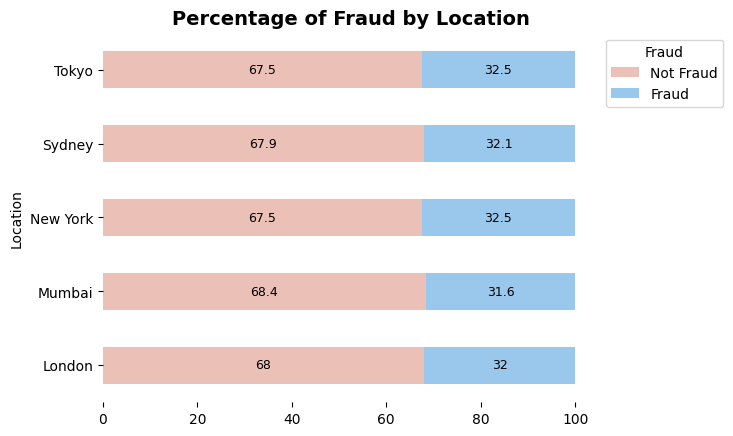

In [26]:
shows_percentage_of_fraud_transaction_for_category("Location")

In [27]:
df.Merchant_Category.unique()

array(['Travel', 'Clothing', 'Restaurants', 'Electronics', 'Groceries'],
      dtype=object)

In [28]:
df.Merchant_Category.value_counts()

Merchant_Category
Clothing       10033
Groceries      10019
Travel         10015
Restaurants     9976
Electronics     9957
Name: count, dtype: int64

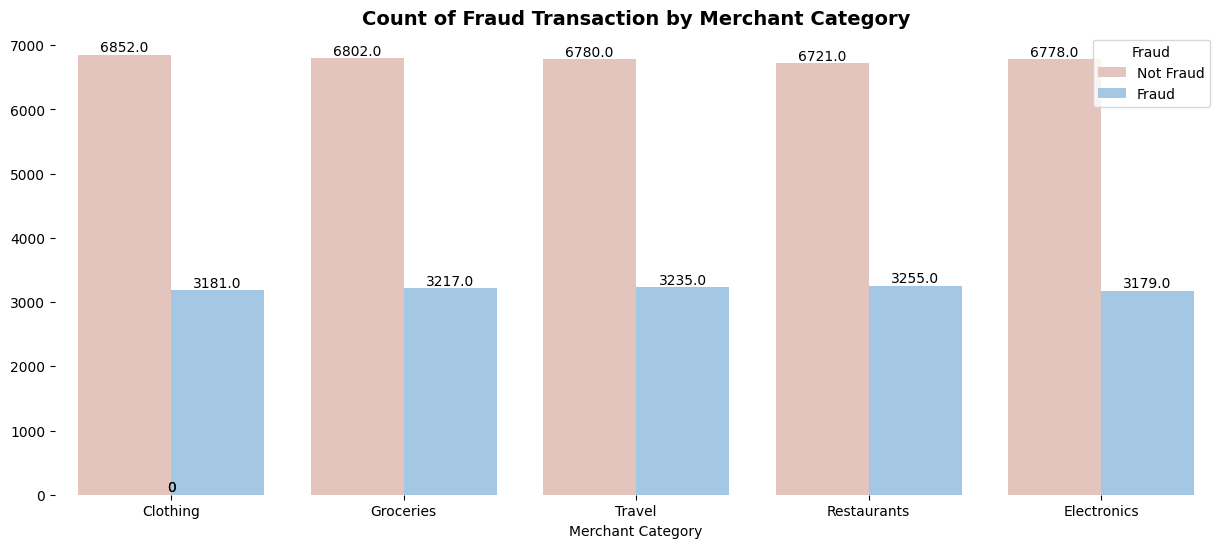

In [29]:
shows_how_many_fraud_transaction_for_category("Merchant_Category")

<Figure size 1500x500 with 0 Axes>

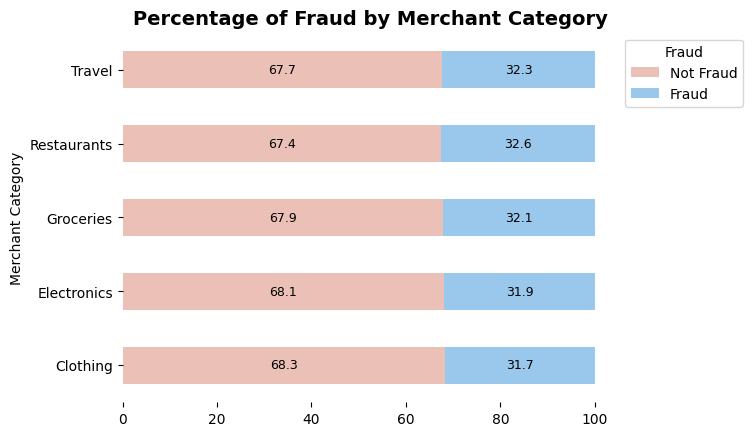

In [30]:
shows_percentage_of_fraud_transaction_for_category("Merchant_Category")

In [31]:
df.Card_Type.unique()

array(['Amex', 'Mastercard', 'Visa', 'Discover'], dtype=object)

In [32]:
df.Card_Type.value_counts()

Card_Type
Mastercard    12693
Visa          12560
Amex          12419
Discover      12328
Name: count, dtype: int64

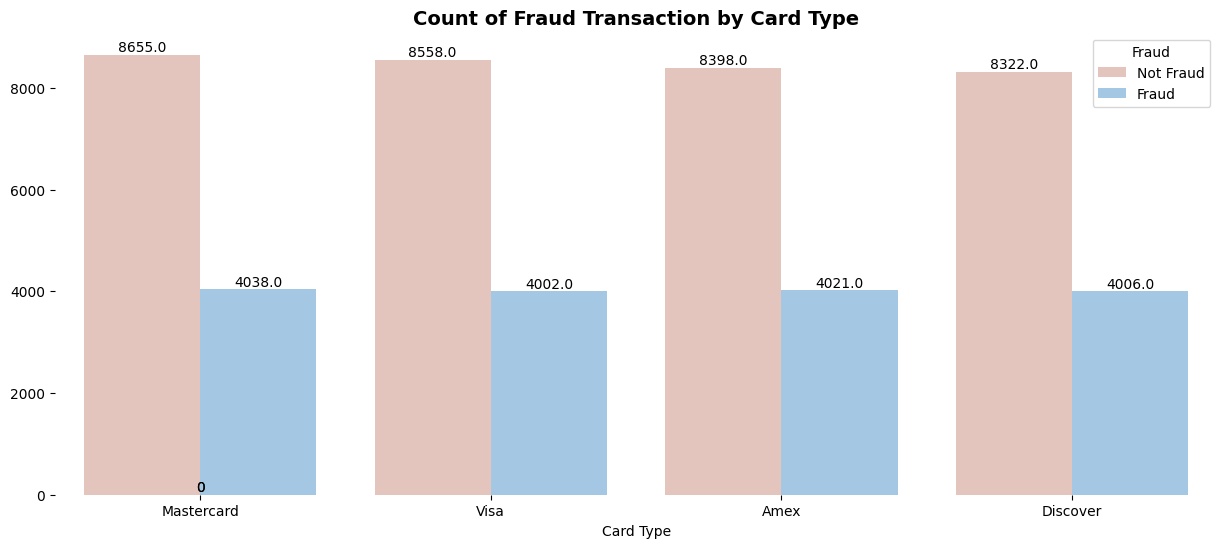

In [33]:
shows_how_many_fraud_transaction_for_category("Card_Type")

<Figure size 1500x500 with 0 Axes>

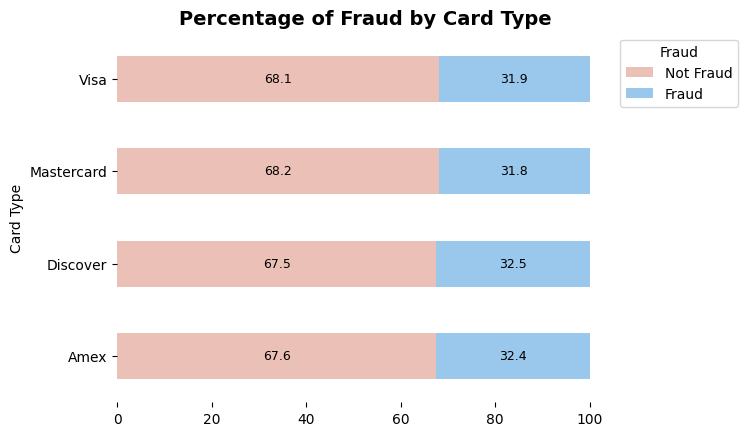

In [34]:
shows_percentage_of_fraud_transaction_for_category("Card_Type")

In [35]:
df.Authentication_Method.unique()

array(['Biometric', 'Password', 'OTP', 'PIN'], dtype=object)

In [36]:
df.Authentication_Method.value_counts()

Authentication_Method
Biometric    12591
PIN          12586
Password     12457
OTP          12366
Name: count, dtype: int64

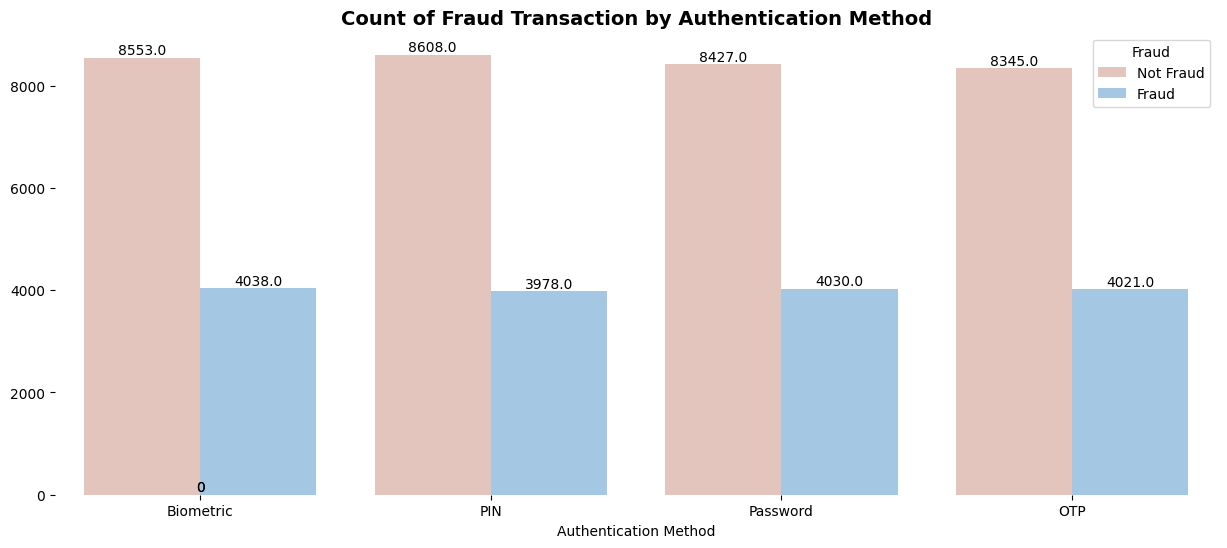

In [37]:
shows_how_many_fraud_transaction_for_category("Authentication_Method")

<Figure size 1500x500 with 0 Axes>

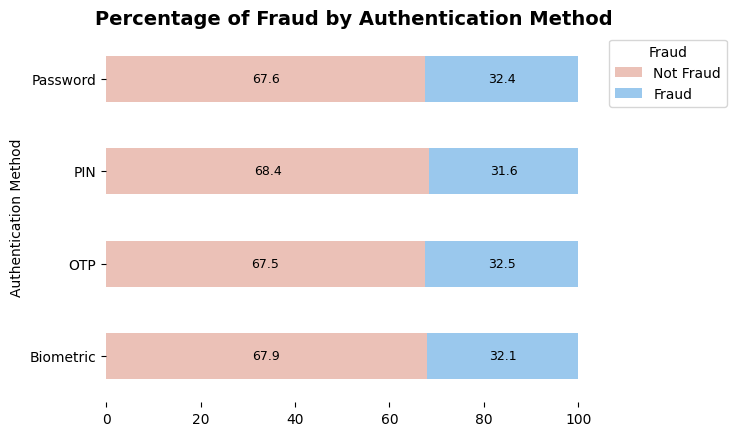

In [38]:
shows_percentage_of_fraud_transaction_for_category("Authentication_Method")

In [39]:
df.select_dtypes('int').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   IP_Address_Flag               50000 non-null  int64
 1   Previous_Fraudulent_Activity  50000 non-null  int64
 2   Daily_Transaction_Count       50000 non-null  int64
 3   Failed_Transaction_Count_7d   50000 non-null  int64
 4   Card_Age                      50000 non-null  int64
 5   Is_Weekend                    50000 non-null  int64
 6   Fraud_Label                   50000 non-null  int64
dtypes: int64(7)
memory usage: 2.7 MB


In [40]:
df.IP_Address_Flag.unique()

array([0, 1], dtype=int64)

In [41]:
df.IP_Address_Flag.value_counts()

IP_Address_Flag
0    47490
1     2510
Name: count, dtype: int64

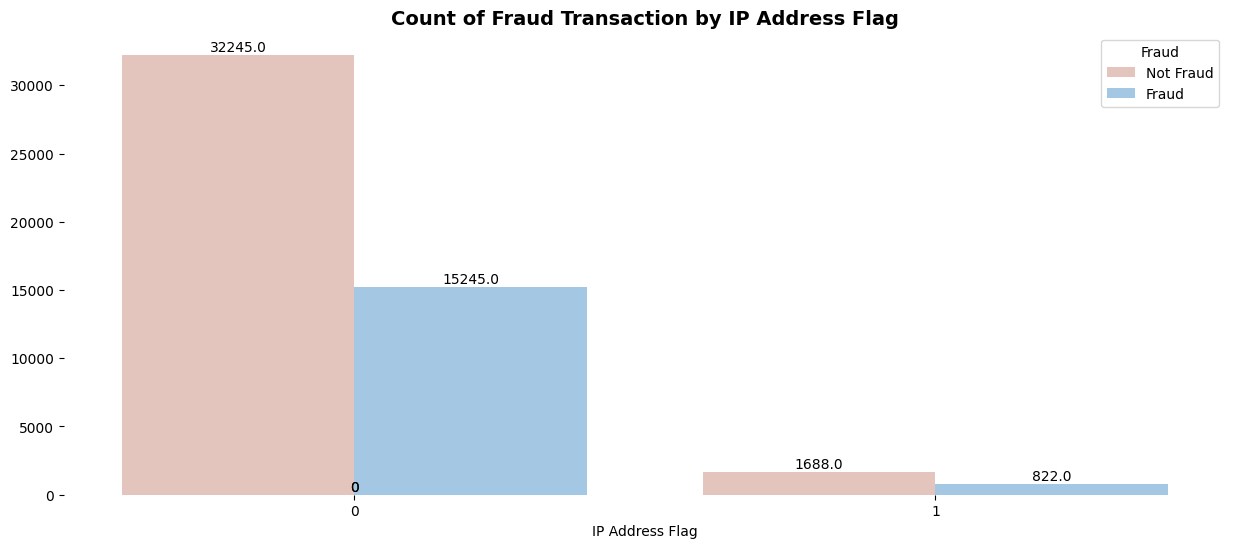

In [42]:
shows_how_many_fraud_transaction_for_category("IP_Address_Flag")

<Figure size 1500x500 with 0 Axes>

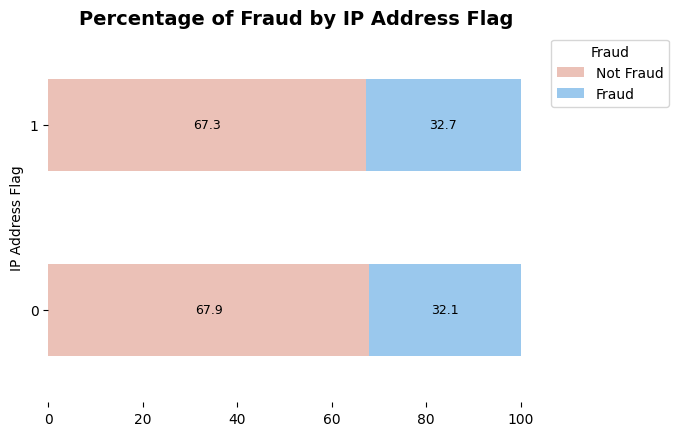

In [43]:
shows_percentage_of_fraud_transaction_for_category("IP_Address_Flag")

In [44]:
df.Previous_Fraudulent_Activity.unique()

array([0, 1], dtype=int64)

In [45]:
df.Previous_Fraudulent_Activity.value_counts()

Previous_Fraudulent_Activity
0    45080
1     4920
Name: count, dtype: int64

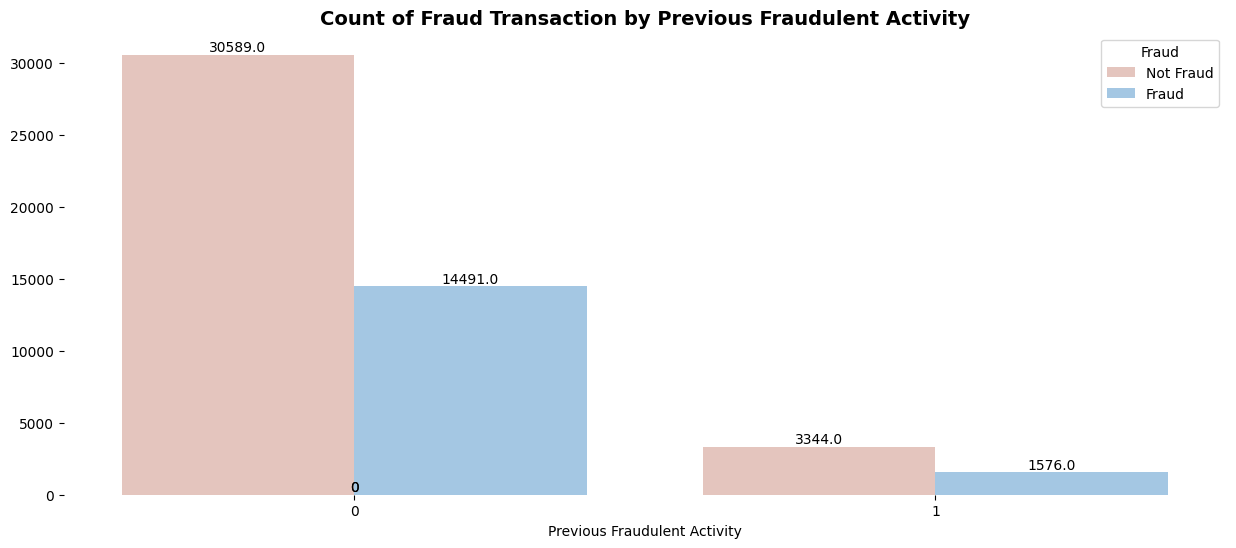

In [46]:
shows_how_many_fraud_transaction_for_category("Previous_Fraudulent_Activity")

<Figure size 1500x500 with 0 Axes>

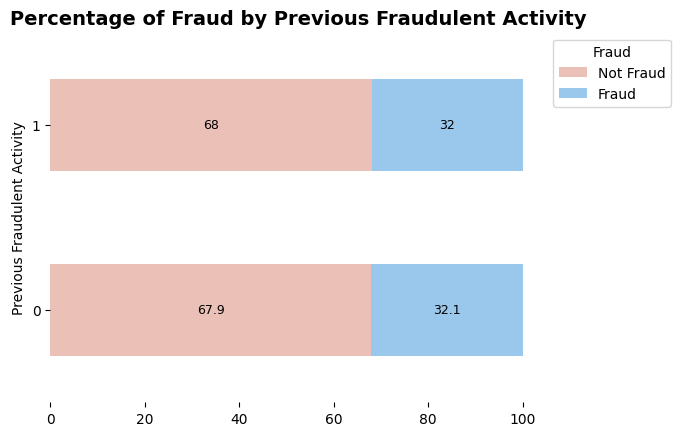

In [47]:
shows_percentage_of_fraud_transaction_for_category("Previous_Fraudulent_Activity")

In [48]:
df.Daily_Transaction_Count.unique()

array([ 7, 13, 14,  8,  3,  2,  6,  4, 11,  1, 12,  9,  5, 10],
      dtype=int64)

In [49]:
df.Daily_Transaction_Count.value_counts()

Daily_Transaction_Count
3     3634
10    3623
11    3620
4     3606
2     3605
1     3598
12    3586
5     3582
7     3574
14    3571
9     3538
13    3524
6     3521
8     3418
Name: count, dtype: int64

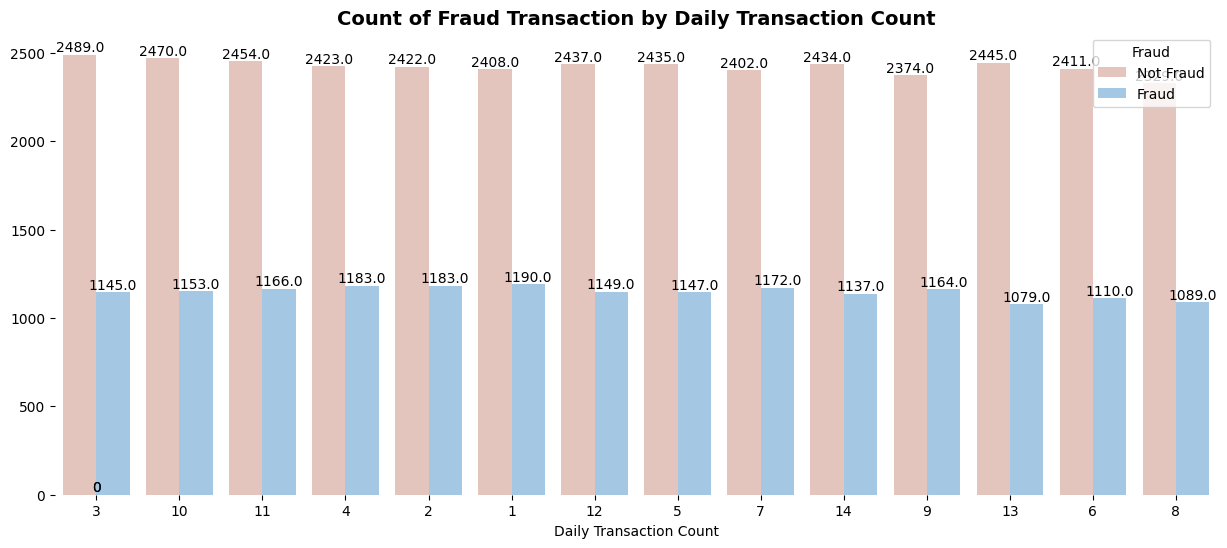

In [50]:
shows_how_many_fraud_transaction_for_category("Daily_Transaction_Count")

<Figure size 1500x500 with 0 Axes>

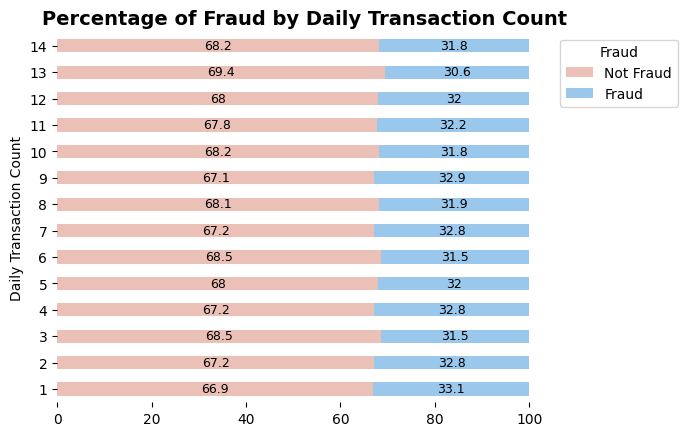

In [51]:
shows_percentage_of_fraud_transaction_for_category("Daily_Transaction_Count")

In [52]:
df.Failed_Transaction_Count_7d.unique()

array([3, 4, 2, 1, 0], dtype=int64)

In [53]:
df.Failed_Transaction_Count_7d.value_counts()

Failed_Transaction_Count_7d
3    10216
0    10014
4     9954
1     9919
2     9897
Name: count, dtype: int64

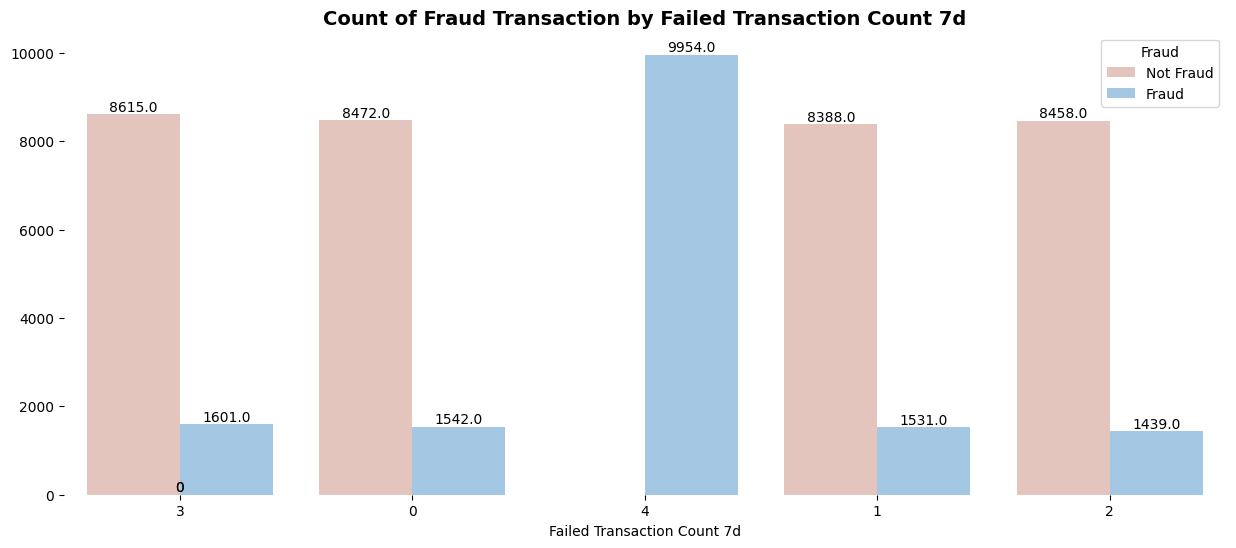

In [54]:
shows_how_many_fraud_transaction_for_category("Failed_Transaction_Count_7d")

<Figure size 1500x500 with 0 Axes>

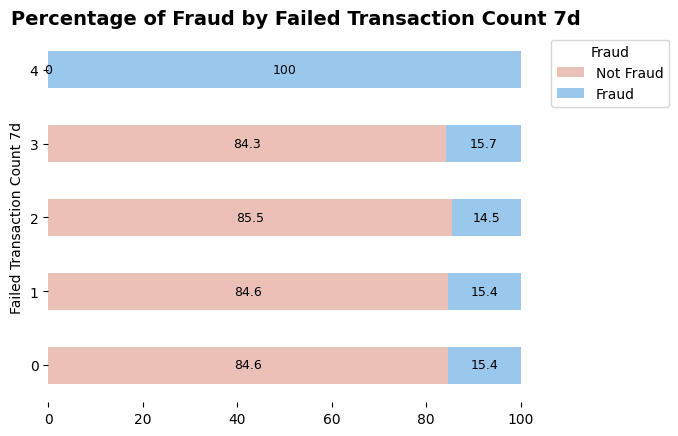

In [55]:
shows_percentage_of_fraud_transaction_for_category("Failed_Transaction_Count_7d")

In [56]:
np.sort(df.Card_Age.unique())

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [57]:
df.Card_Age.value_counts().describe()

count    239.000000
mean     209.205021
std       14.230833
min      167.000000
25%      199.500000
50%      210.000000
75%      219.000000
max      247.000000
Name: count, dtype: float64

In [58]:
df.Is_Weekend.unique()

array([0, 1], dtype=int64)

In [59]:
df.Is_Weekend.value_counts()

Is_Weekend
0    35018
1    14982
Name: count, dtype: int64

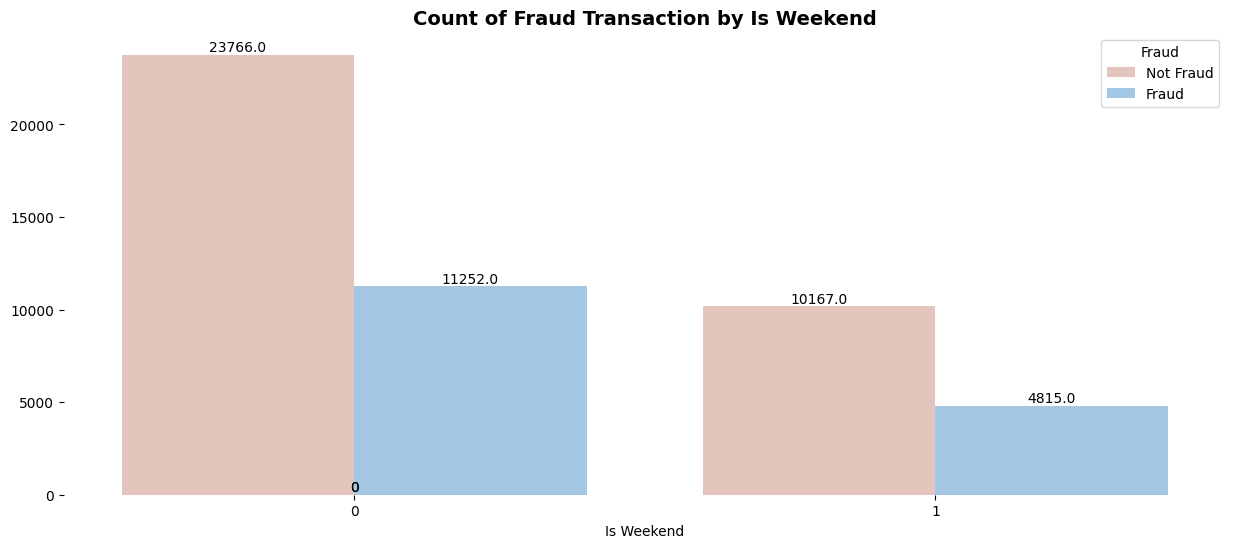

In [60]:
shows_how_many_fraud_transaction_for_category("Is_Weekend")

<Figure size 1500x500 with 0 Axes>

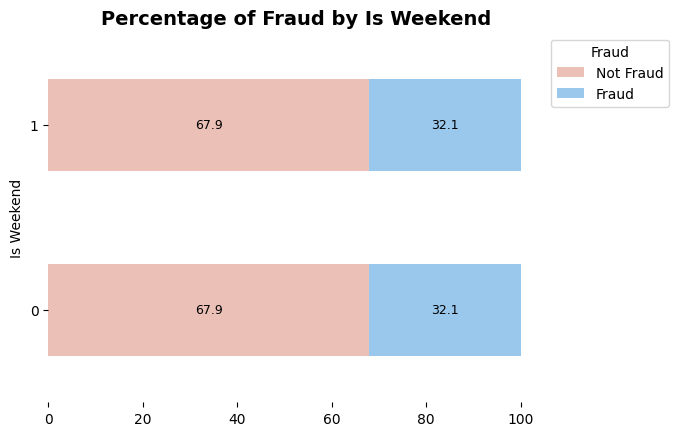

In [61]:
shows_percentage_of_fraud_transaction_for_category("Is_Weekend")

In [62]:
df.Fraud_Label.unique()

array([0, 1], dtype=int64)

In [63]:
df.Fraud_Label.value_counts()

Fraud_Label
0    33933
1    16067
Name: count, dtype: int64

In [64]:
df.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transaction_Amount         50000 non-null  float64
 1   Account_Balance            50000 non-null  float64
 2   Avg_Transaction_Amount_7d  50000 non-null  float64
 3   Transaction_Distance       50000 non-null  float64
 4   Risk_Score                 50000 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB


In [65]:
df.select_dtypes('float').describe()

,Transaction_Amount,Account_Balance,Avg_Transaction_Amount_7d,Transaction_Distance,Risk_Score
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,99.411012,50294.065981,255.271924,2499.164155,0.501556
std,98.687292,28760.458557,141.382279,1442.013834,0.287774
min,0.000000,500.480000,10.000000,0.250000,0.000100
25%,28.677500,25355.995000,132.087500,1256.497500,0.254000
50%,69.660000,50384.430000,256.085000,2490.785000,0.502250
75%,138.852500,75115.135000,378.032500,3746.395000,0.749525
max,1174.140000,99998.310000,500.000000,4999.930000,1.000000


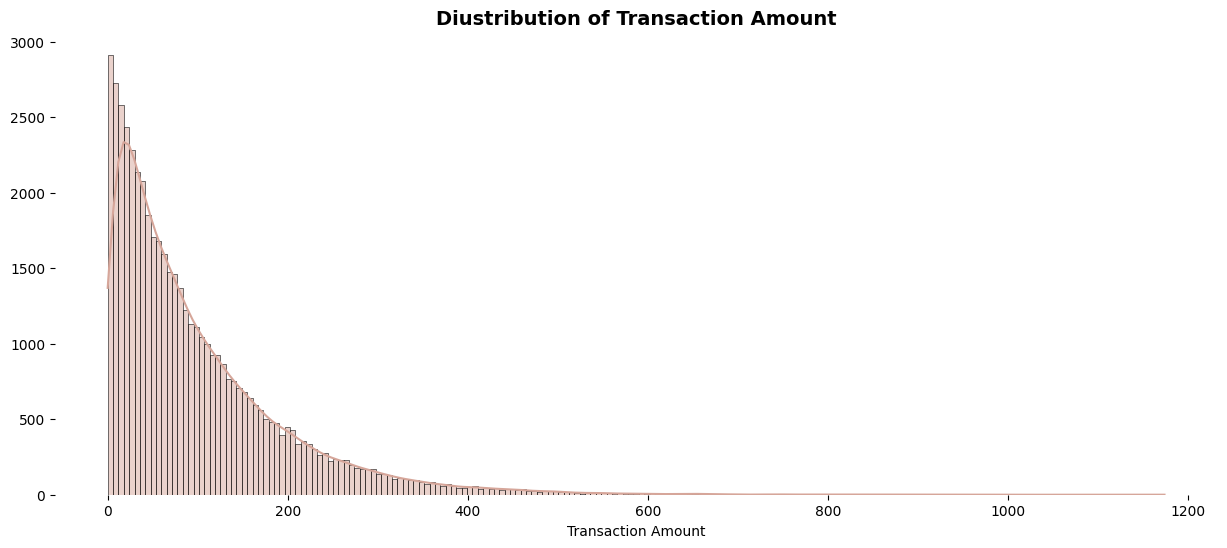

In [66]:
show_distribution("Transaction_Amount", df)

C:\Users\Dell\AppData\Local\Temp\ipykernel_26360\1431986279.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data,


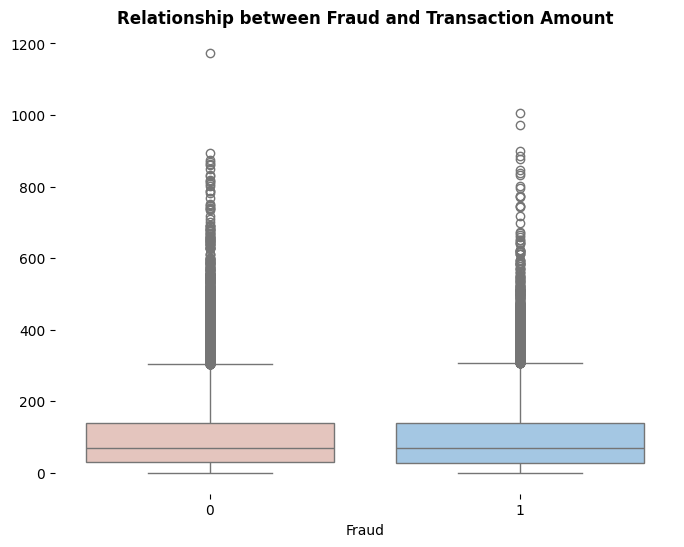

In [67]:
show_present_of_outliers("Transaction_Amount", df)

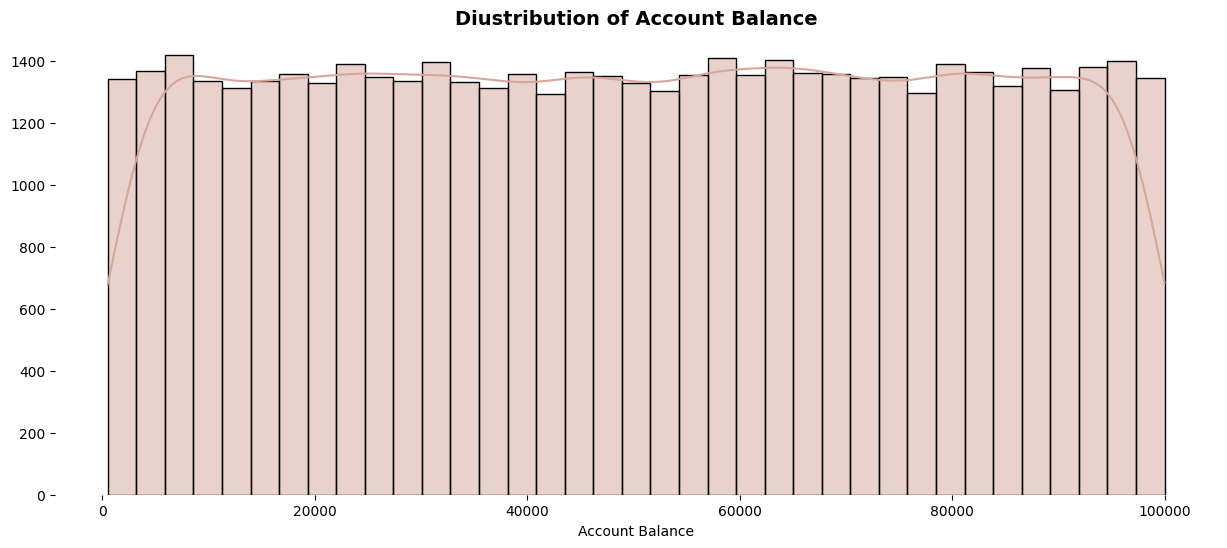

In [68]:
show_distribution("Account_Balance", df)

C:\Users\Dell\AppData\Local\Temp\ipykernel_26360\1431986279.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data,


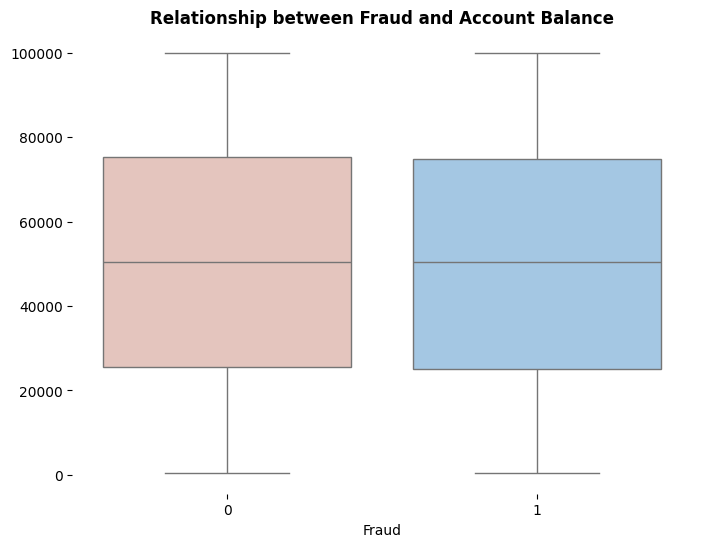

In [69]:
show_present_of_outliers("Account_Balance", df)

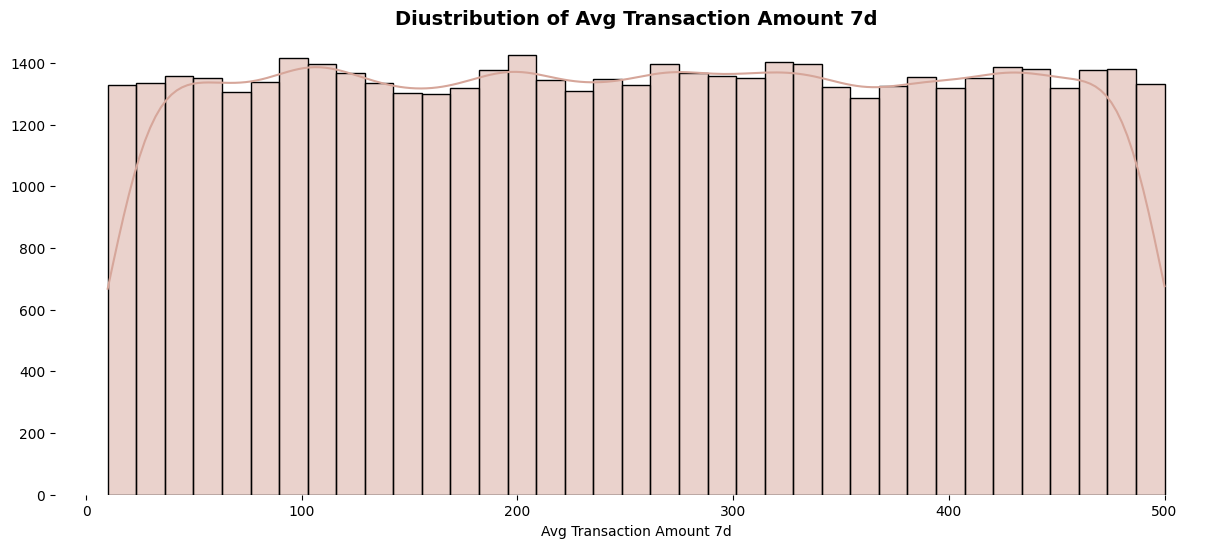

In [70]:
show_distribution("Avg_Transaction_Amount_7d", df)

C:\Users\Dell\AppData\Local\Temp\ipykernel_26360\1431986279.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data,


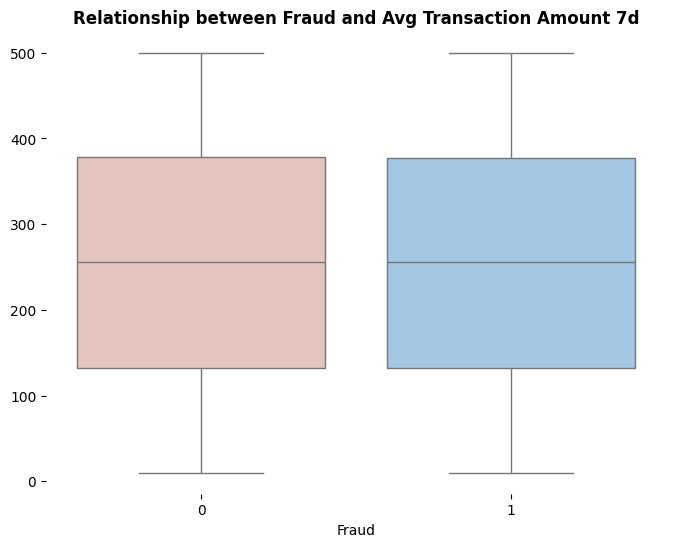

In [71]:
show_present_of_outliers("Avg_Transaction_Amount_7d", df)

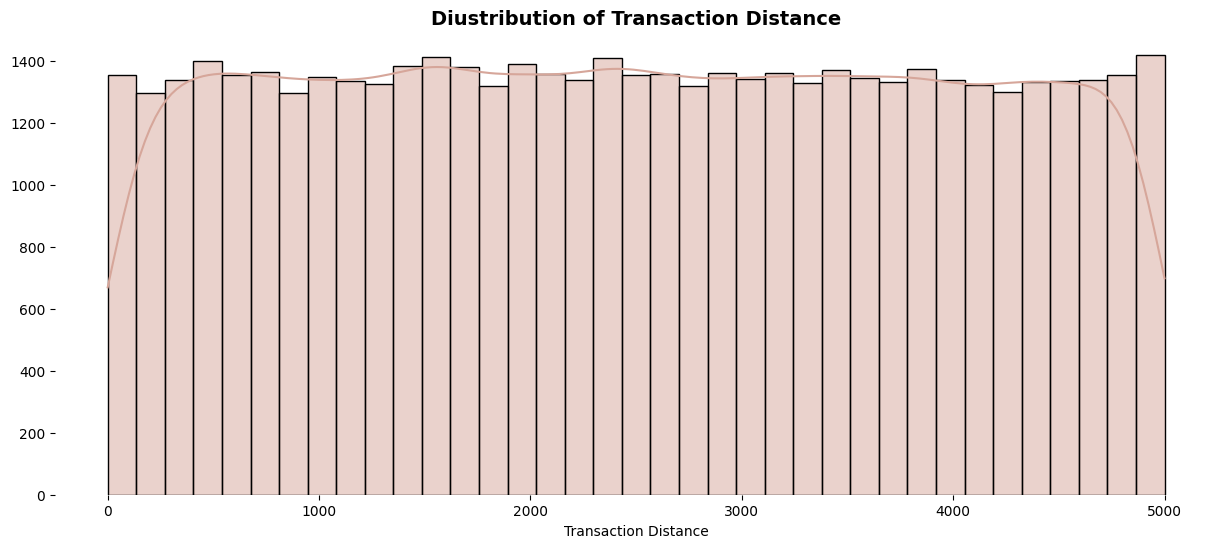

In [72]:
show_distribution("Transaction_Distance", df)

C:\Users\Dell\AppData\Local\Temp\ipykernel_26360\1431986279.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data,


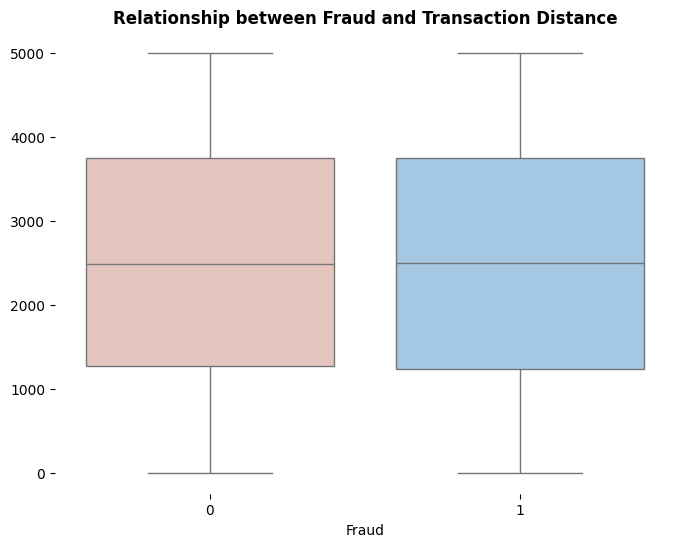

In [73]:
show_present_of_outliers("Transaction_Distance", df)

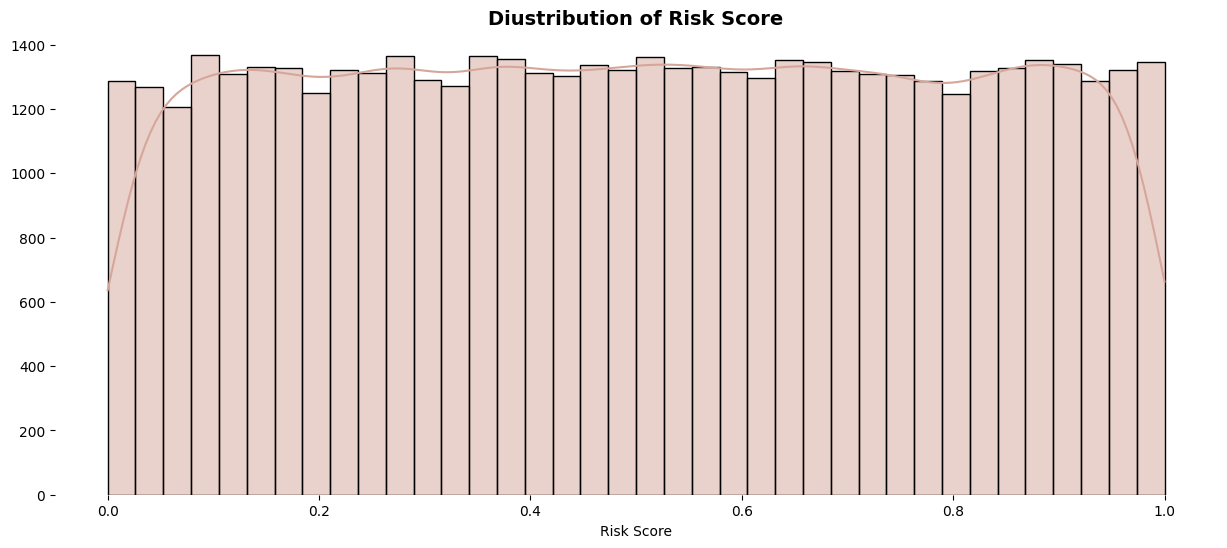

In [74]:
show_distribution("Risk_Score", df)

C:\Users\Dell\AppData\Local\Temp\ipykernel_26360\1431986279.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data,


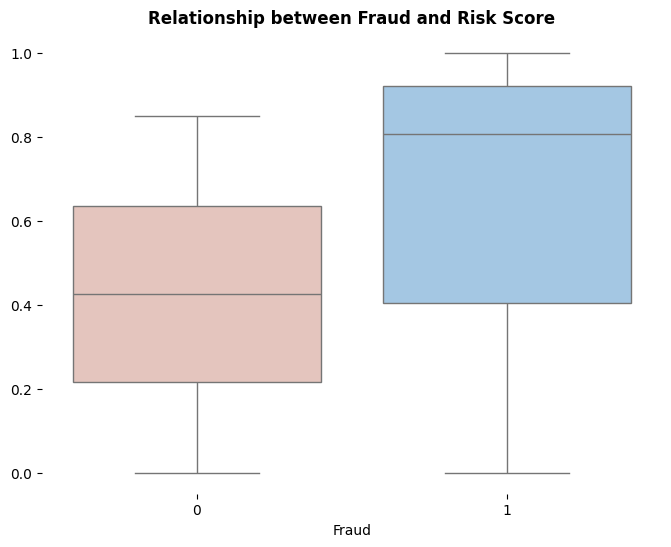

In [75]:
show_present_of_outliers("Risk_Score", df)

In [76]:
df.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transaction_Amount         50000 non-null  float64
 1   Account_Balance            50000 non-null  float64
 2   Avg_Transaction_Amount_7d  50000 non-null  float64
 3   Transaction_Distance       50000 non-null  float64
 4   Risk_Score                 50000 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB


In [77]:
# Step 2: Remove outliers using Z-score
z_scores = np.abs(zscore(df[['Transaction_Amount', 'Account_Balance', 'Avg_Transaction_Amount_7d', 'Transaction_Distance', 'Risk_Score']]))
df_clean = df[(z_scores < 2).all(axis=1)]  # Remove rows where Z-score > 2 or < -2

print(f"Dataset size before outlier removal: {df.shape}")
print(f"Dataset size after outlier removal: {df_clean.shape}")

Dataset size before outlier removal: (50000, 21)
Dataset size after outlier removal: (47566, 21)


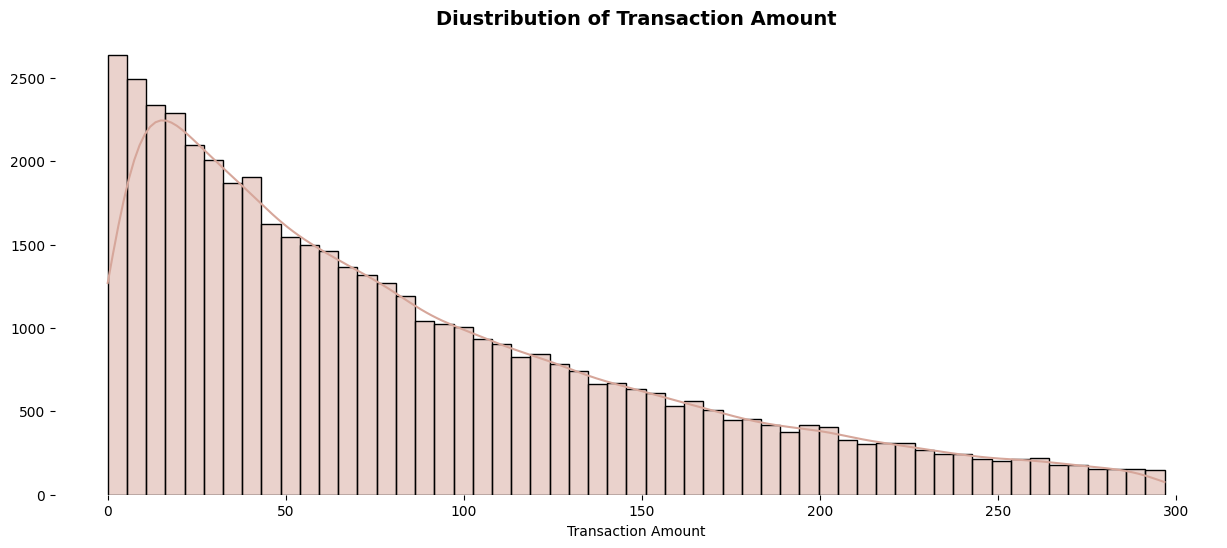

In [78]:
show_distribution("Transaction_Amount", df_clean)

C:\Users\Dell\AppData\Local\Temp\ipykernel_26360\1431986279.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data,


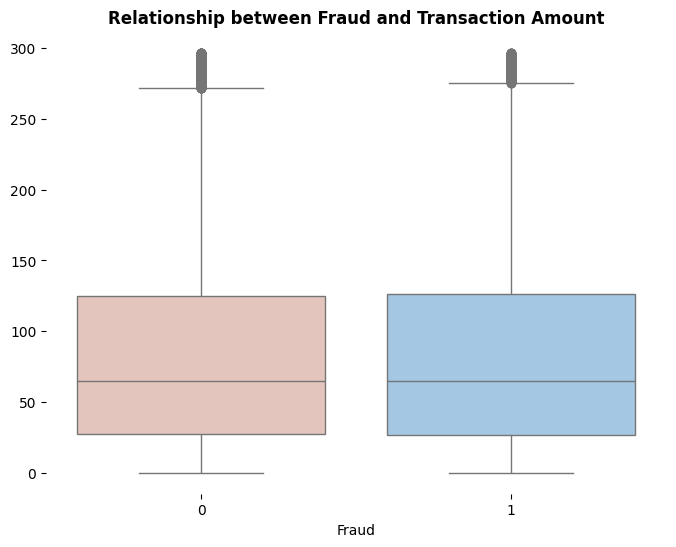

In [79]:
show_present_of_outliers("Transaction_Amount", df_clean)

In [80]:
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         50000 non-null  object
 1   User_ID                50000 non-null  object
 2   Transaction_Type       50000 non-null  object
 3   Timestamp              50000 non-null  object
 4   Device_Type            50000 non-null  object
 5   Location               50000 non-null  object
 6   Merchant_Category      50000 non-null  object
 7   Card_Type              50000 non-null  object
 8   Authentication_Method  50000 non-null  object
dtypes: object(9)
memory usage: 3.4+ MB


In [81]:
df_clean = df_clean.drop(columns=['Transaction_ID', 'User_ID', 'Timestamp'])

In [82]:
# One-Hot Encoding categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = df_clean.select_dtypes(include=['object']).columns
encoded_array = encoder.fit_transform(df_clean[categorical_cols])

In [83]:
# Create a DataFrame with encoded columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols)).astype(int)
encoded_df.head()

,Transaction_Type_Bank Transfer,Transaction_Type_Online,Transaction_Type_POS,Device_Type_Mobile,Device_Type_Tablet,Location_Mumbai,Location_New York,Location_Sydney,Location_Tokyo,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,Authentication_Method_OTP,Authentication_Method_PIN,Authentication_Method_Password
0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1


In [84]:
# Drop original categorical columns and concatenate new one-hot encoded columns
df_clean = df_clean.drop(columns=categorical_cols).reset_index(drop=True)
df_clean = pd.concat([df_clean, encoded_df], axis=1)
df_clean.head()

,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,...,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,Authentication_Method_OTP,Authentication_Method_PIN,Authentication_Method_Password
0,39.79,93213.17,0,0,7,437.63,3,65,883.17,0.8494,...,0,0,0,1,0,0,0,0,0,0
1,1.19,75725.25,0,0,13,478.76,4,186,2203.36,0.0959,...,0,0,0,0,0,1,0,0,0,1
2,28.96,1588.96,0,0,14,50.01,4,226,1909.29,0.8400,...,0,0,1,0,0,0,1,0,0,0
3,254.32,76807.20,0,0,8,182.48,4,76,1311.86,0.7935,...,0,0,0,0,0,0,1,1,0,0
4,31.28,92354.66,0,1,14,328.69,4,140,966.98,0.3819,...,1,0,0,0,0,1,0,0,0,1


In [85]:
scaler = StandardScaler()
X = df_clean.drop(['Fraud_Label'], axis=1)
y = df_clean['Fraud_Label']
X_scaled = X.copy()
# Select the numerical features for scaling
numerical_features = X.select_dtypes(include=['float']).columns
# Fit and transform the StandardScaler on the numerical features data
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

In [86]:
X_scaled.head()

,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,...,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,Authentication_Method_OTP,Authentication_Method_PIN,Authentication_Method_Password
0,-0.629550,1.490164,0,0,7,1.289966,3,65,-1.118227,1.208733,...,0,0,0,1,0,0,0,0,0,0
1,-1.176416,0.882445,0,0,13,1.580850,4,186,-0.203175,-1.409106,...,0,0,0,0,0,1,0,0,0,1
2,-0.782985,-1.693849,0,0,14,-1.451408,4,226,-0.407001,1.176076,...,0,0,1,0,0,0,1,0,0,0
3,2.409805,0.920044,0,0,8,-0.514538,4,76,-0.821093,1.014524,...,0,0,0,0,0,0,1,1,0,0
4,-0.750116,1.460330,0,1,14,0.519507,4,140,-1.060137,-0.415473,...,1,0,0,0,0,1,0,0,0,1


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [88]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (38052, 30)
X_test shape:  (9514, 30)
y_train shape: (38052,)
y_test shape:  (9514,)


In [88]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'kernel': ['rbf']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 5, 10, 20, 50],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'K_Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10],
            'subsample': [0.8, 1.0],
            'min_child_weight': [1, 3, 5]
        }
    }
}


In [89]:
scores = []

for model_name, mp in model_params.items():
    print(f"{model_name} Started")
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, verbose=3)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_
    })
    print(f"{model_name} End")

svm Started
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...................C=1, kernel=rbf;, score=0.927 total time= 1.1min
[CV 2/5] END ...................C=1, kernel=rbf;, score=0.931 total time= 1.1min
[CV 3/5] END ...................C=1, kernel=rbf;, score=0.926 total time= 1.1min
[CV 4/5] END ...................C=1, kernel=rbf;, score=0.928 total time= 1.1min
[CV 5/5] END ...................C=1, kernel=rbf;, score=0.926 total time= 1.1min
[CV 1/5] END ...................C=5, kernel=rbf;, score=0.950 total time= 2.0min
[CV 2/5] END ...................C=5, kernel=rbf;, score=0.953 total time= 2.1min
[CV 3/5] END ...................C=5, kernel=rbf;, score=0.947 total time= 2.1min
[CV 4/5] END ...................C=5, kernel=rbf;, score=0.951 total time= 2.1min
[CV 5/5] END ...................C=5, kernel=rbf;, score=0.950 total time= 2.1min
[CV 1/5] END ..................C=10, kernel=rbf;, score=0.952 total time= 2.7min
[CV 2/5] END ..................C=10, 

In [90]:
scores

[{'model': 'svm',
  'best_score': 0.9508566496620926,
  'best_params': {'C': 10, 'kernel': 'rbf'},
  'best_estimator': SVC(C=10, gamma='auto')},
 {'model': 'random_forest',
  'best_score': 1.0,
  'best_params': {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 5,
   'n_estimators': 20},
  'best_estimator': RandomForestClassifier(min_samples_split=5, n_estimators=20)},
 {'model': 'K_Neighbors',
  'best_score': 0.8401398798440116,
  'best_params': {'metric': 'manhattan',
   'n_neighbors': 10,
   'weights': 'distance'},
  'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')},
 {'model': 'decision_tree',
  'best_score': 0.9999737222441205,
  'best_params': {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2},
  'best_estimator': DecisionTreeClassifier()},
 {'model': 'xgboost',
  'best_score': 0.9995269762227746,
  'best_params': {'learning_rate': 0.3,
   'max_depth': 3,
   'min_child_weight': 1,
   'n_estimat

In [91]:
scores_df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params', 'best_estimator'])
scores_df

,model,best_score,best_params,best_estimator
0,svm,0.950857,"{'C': 10, 'kernel': 'rbf'}","SVC(C=10, gamma='auto')"
1,random_forest,1.000000,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...","(DecisionTreeClassifier(max_features='sqrt', m..."
2,K_Neighbors,0.840140,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...","KNeighborsClassifier(metric='manhattan', n_nei..."
3,decision_tree,0.999974,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",DecisionTreeClassifier()
4,xgboost,0.999527,"{'learning_rate': 0.3, 'max_depth': 3, 'min_ch...","XGBClassifier(base_score=None, booster=None, c..."


In [92]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [98]:
def result_summary(model, model_name):
    # Cross-Validation Score
    scores = cross_val_score(model, X_scaled, y, cv=5)
    cross_val_score_mean = scores.mean()

    # Predictions
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Classification Report
    cr_test = classification_report(y_test, y_test_pred)
    cr_train = classification_report(y_train, y_train_pred)

    print(f"----------{model_name}----------")
    print("cross_val_score: ")
    print(scores)
    print("cross_val_score_mean: ")
    print(cross_val_score_mean)
    print("classification_report_test_data: ")
    print(cr_test)
    print("classification_report_train_data: ")
    print(cr_train)


In [99]:
# Get best models and evaluate
best_models = [score['best_estimator'] for score in scores]
models_name = [score['model'] for score in scores]

results_list = []

for i in range(len(models_name)):
  result_summary(best_models[i], models_name[i])

----------svm----------
cross_val_score: 
[0.94996847 0.95774204 0.95164512 0.95500894 0.95574477]
cross_val_score_mean: 
0.9540218654795012
classification_report_test_data: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6509
           1       0.92      0.94      0.93      3005

    accuracy                           0.96      9514
   macro avg       0.95      0.95      0.95      9514
weighted avg       0.96      0.96      0.96      9514

classification_report_train_data: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25775
           1       1.00      1.00      1.00     12277

    accuracy                           1.00     38052
   macro avg       1.00      1.00      1.00     38052
weighted avg       1.00      1.00      1.00     38052

----------random_forest----------
cross_val_score: 
[0.99989489 1.         1.         0.99989488 1.        ]
cross_val_score_mean: 
0.99

In [100]:
import time

In [101]:
def test_speed(model, x):
    # Start time
    start_time = time.time()
    
    model.predict(x)
    
    # End time
    end_time = time.time()
    
    return end_time - start_time

In [109]:
# Track execution times
execution_times = {}

for i in range(len(models_name)):
  execution_times[models_name[i]] = test_speed(best_models[i], X_test[:1])

In [107]:
X_test[:1]

,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,...,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,Authentication_Method_OTP,Authentication_Method_PIN,Authentication_Method_Password
42237,-1.176841,0.267367,0,0,6,-0.119124,2,19,-1.658786,0.906475,...,0,0,0,0,0,0,1,0,1,0


In [110]:
execution_times

{'svm': 0.004936695098876953,
 'random_forest': 0.0033049583435058594,
 'K_Neighbors': 0.008615732192993164,
 'decision_tree': 0.002621173858642578,
 'xgboost': 0.028710603713989258}

In [112]:
# Print the fastest model
fastest_model = min(execution_times, key=execution_times.get)
print(f"🏆 Fastest model:, {fastest_model}, with time:, {execution_times[fastest_model]}, seconds")

🏆 Fastest model:, decision_tree, with time:, 0.002621173858642578, seconds


In [116]:
best_models[3]

DecisionTreeClassifier()

In [117]:
# Save the model
joblib.dump(best_models[3], 'fraud_detection_transactions_decision_tree_model.pkl')

['fraud_detection_transactions_decision_tree_model.pkl']

In [118]:
scaler

StandardScaler()

In [121]:
# Save the scaler
joblib.dump(scaler, 'fraud_detection_transactions_scaler.pkl')

['fraud_detection_transactions_scaler.pkl']

In [119]:
encoder

OneHotEncoder(drop='first', sparse_output=False)

In [122]:
# Save the encoder
joblib.dump(encoder, 'fraud_detection_transactions_encoder.pkl')

['fraud_detection_transactions_encoder.pkl']

In [89]:
model = joblib.load("fraud_detection_transactions_decision_tree_model.pkl")

In [91]:
model.predict(X_test[:1])[0]

0

In [113]:
df[:1].Is_Weekend

0    0
Name: Is_Weekend, dtype: int64

In [ ]:
Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Timestamp', 'Account_Balance', 'Device_Type', 'Location',
       'Merchant_Category', 'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
       'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend', 'Fraud_Label'],
      dtype='object')

In [100]:
df[:1]

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
